In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import cPickle as pickle
from spiketopics.helpers import *

%matplotlib inline
sns.set_style('darkgrid')

# Load in data

In [2]:
infile = 'data/fitted_model_object.pkl'
gpm = pickle.load(open(infile, 'rb'))
dt = 0.020

In [3]:
gpm.Nframe.head()

,unit,time,count,lam0,lam1
0,0,0,2,-0.853716,-0.928713
1,0,1,1,-0.707843,-0.727966
2,0,2,2,-0.754348,-0.835490
3,0,3,0,-0.606758,-0.569237
4,0,4,2,-0.759080,-0.839929


In [4]:
if gpm.regressors:
    gpm.Xframe.head()

# Plot inferred categories as matrix

In [5]:
xi = gpm.nodes['HMM'].nodes['z'].z[1]
T, K = xi.shape
print xi.shape

(236008, 5)


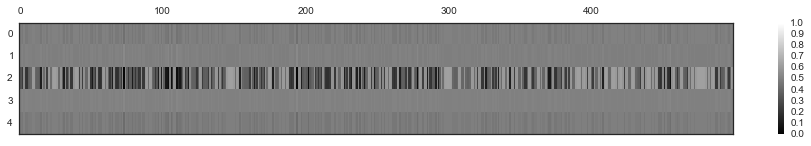

In [6]:
matshow(xi[:500].T, vmin=0, vmax=1);
plt.colorbar();

## Make $\xi$ dataframe:

In [7]:
xif = pd.DataFrame(xi)
xif.columns = ['Z' + str(k) for k in range(K)]
xif.index.name = 'time'
xif = xif.reset_index()

# Posteriors for effects

## Baselines

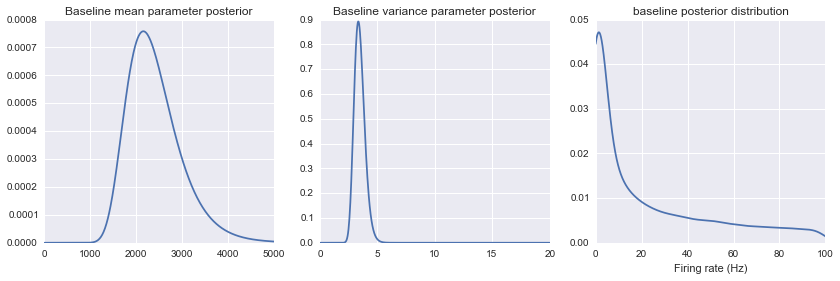

In [8]:
plt.figure(figsize=(14, 4))

th = gpm.nodes['baseline_mean']
cc = gpm.nodes['baseline_shape']
th_pars = [th.post_shape, th.post_rate]
cc_pars = [cc.post_shape, cc.post_rate]
samples = gamma_from_hypers(th_pars, cc_pars, 1e5)

plt.subplot(1, 3, 1)
xx = np.linspace(0, 5000, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0], scale=th_pars[1]/dt))
plt.title('Baseline mean parameter posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 20, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0], scale=cc_pars[1]))
plt.title('Baseline variance parameter posterior');

plt.subplot(1, 3, 3)
sns.kdeplot(samples / dt, gridsize=1e4, clip=(0, 100))
plt.title('baseline posterior distribution')
plt.xlabel('Firing rate (Hz)')
plt.xlim(0, 100);

## Regressors

In [9]:
if gpm.regressors:
    plt.figure(figsize=(8, 6));
    inferred_means = gpm.nodes['fr_regressors'].expected_x()
    R = inferred_means.shape[1]
    for r in xrange(R):
        plt.hist(inferred_means[:, r], bins=50, normed=True, alpha=0.25, label='X' + str(r))
    plt.title('Regression effects');
    plt.legend()
    plt.ylim(0, 5);
    plt.xlim(0, 5);

## Latent Categories

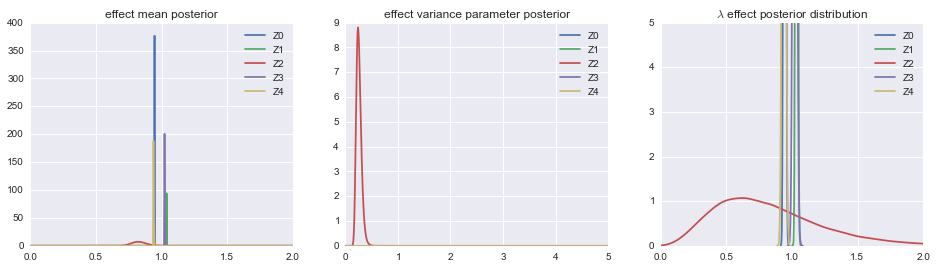

In [10]:
plt.figure(figsize=(16, 4))

th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']

th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

plt.subplot(1, 3, 1)
xx = np.linspace(0, 2, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0, kk], scale=th_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect mean posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 5, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0, kk], scale=cc_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect variance parameter posterior');

plt.subplot(1, 3, 3)
for kk in xrange(K):
    samples = gamma_from_hypers(th_pars[:, kk], cc_pars[:, kk], 1e5)
    sns.kdeplot(samples, gridsize=1e4, clip=(0, 10), label='Z' + str(kk))
plt.legend()
plt.title(r'$\lambda$ effect posterior distribution')
plt.xlim(0, 2);
plt.ylim(0, 5);

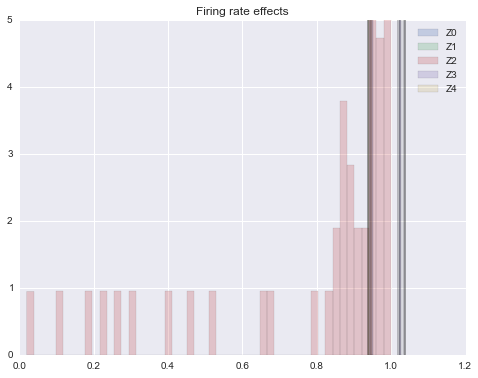

In [11]:
plt.figure(figsize=(8, 6))

inferred_effects = gpm.nodes['fr_latents'].expected_x()
for kk in xrange(K):
    plt.hist(inferred_effects[..., kk], bins=50, normed=True, alpha=0.25, label='Z' + str(kk));
plt.legend();
plt.title('Firing rate effects');
plt.ylim(0, 5);

## Overdispersion

In [12]:
if gpm.overdispersion:
    plt.figure(figsize=(8, 6))

    inferred_means = gpm.nodes['overdispersion'].expected_x().ravel()
    plt.hist(inferred_means, bins=500, normed=True, alpha=0.25);
    plt.title('Overdispersion effects');
    plt.ylim(0, 2);

# Load and prepare ethogram:

Our goal here is to load the ethogram, join it to the inferred ethogram, and perform some comparisons to see if any of our discovered categories match hand-labeled categories from the ethogram.

In [13]:
ethofile = 'sql/etho.csv'
etho = pd.read_csv(ethofile)

/Users/jmxp/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [14]:
# rename some columns
etho = etho.rename(columns={'movieId': 'movie', 'frameNumber': 'frame'})
etho = frames_to_times(etho)

In [15]:
etho.head()

,frameTime,ethoCameraLabel,ethoCameraLevel,ethoCameraHolding,ethoCameraZoomingIn,ethoCameraZoomingOut,ethoCameraTracking,ethoCameraPanning,ethoCameraSlewing,ethoRoughCountLabel,...,ethoChase,ethoFlee,ethoThreaten,ethoMountedThreaten,ethoSubmit,ethoDisplace,ethoLeanAway,ethoAvoid,ethoBranchDisplay,time
0,0.0000,holding,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0333,holding,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.0667,holding,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0.1000,holding,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0.1333,holding,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [16]:
# merge labeled and inferred etho on movie and frame columns
edf = pd.merge(etho, xif, how='right')
edf.columns

Index([u'frameTime', u'ethoCameraLabel', u'ethoCameraLevel', u'ethoCameraHolding', u'ethoCameraZoomingIn', u'ethoCameraZoomingOut', u'ethoCameraTracking', u'ethoCameraPanning', u'ethoCameraSlewing', u'ethoRoughCountLabel', u'ethoRoughCountLevel', u'ethoCountNone', u'ethoLeast1', u'ethoLeast2', u'ethoLeast3', u'ethoLeast6', u'ethoLeast11', u'ethoHumanVisible', u'ethoFaceLabel', u'ethoFaceViewLevel', u'ethoFaceNone', u'ethoFaceVisible', u'ethoFaceProminent', u'ethoFaceDirect', u'ethoFaceEyeContact', u'ethoGenitalsLabel', u'ethoGenitalsViewLevel', u'ethoGenitalsNone', u'ethoGenitalsVisible', u'ethoGenitalsProminent', u'ethoGenitalsMale', u'ethoGenitalsFemale', u'ethoGenitalsBoth', u'ethoForageLabel', u'ethoForageLevel', u'ethoForage', u'ethoMassForage', u'ethoDrink', u'ethoSearch', u'ethoGraspFood', u'ethoHoldFood', u'ethoHoldInMouth', u'ethoManipulateFood', u'ethoIngestFood', u'ethoIngestFromGroom', u'ethoChew', u'ethoRetrieveFromPouch', u'ethoHeave', u'ethoAllogroom', u'ethoSolicitAllog

In [17]:
# get rid of categories that are either identifiers or have non-binary entries
edf = edf.drop(['frameTime', 'ethoCameraLabel', 'ethoFaceLabel',
                'ethoGenitalsLabel', 'ethoForageLabel', 'ethoAggressionLabel', 'time',
                'ethoCameraLevel',
                'ethoRoughCountLabel', 'ethoRoughCountLevel', 'ethoFaceViewLevel', 
                'ethoGenitalsViewLevel', 'ethoForageLevel', 'ethoAggressionLevel'], axis=1)


In [18]:
edf.head()

,ethoCameraHolding,ethoCameraZoomingIn,ethoCameraZoomingOut,ethoCameraTracking,ethoCameraPanning,ethoCameraSlewing,ethoCountNone,ethoLeast1,ethoLeast2,ethoLeast3,...,Z10,Z11,Z12,Z13,Z14,Z15,Z16,Z17,Z18,Z19
0,1,0,0,0,0,0,1,0,0,0,...,0.018976,0.016140,0.009712,0.026715,0.014289,0.036001,0.035086,0.035877,0.039537,0.054616
1,1,0,0,0,0,0,1,0,0,0,...,0.031887,0.023652,0.010730,0.033458,0.011502,0.106704,0.040757,0.044329,0.041161,0.066881
2,1,0,0,0,0,0,1,0,0,0,...,0.042886,0.029466,0.012650,0.041811,0.013632,0.152168,0.052968,0.060855,0.055163,0.078415
3,1,0,0,0,0,0,1,0,0,0,...,0.053013,0.034403,0.014373,0.049471,0.015884,0.184176,0.069540,0.080775,0.074887,0.089637
4,1,0,0,0,0,0,1,0,0,0,...,0.061794,0.038542,0.015881,0.056371,0.018277,0.207210,0.088185,0.101563,0.094449,0.100364


# View results:

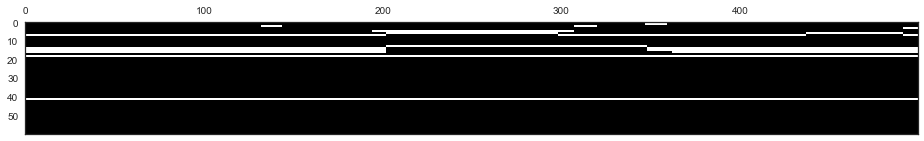

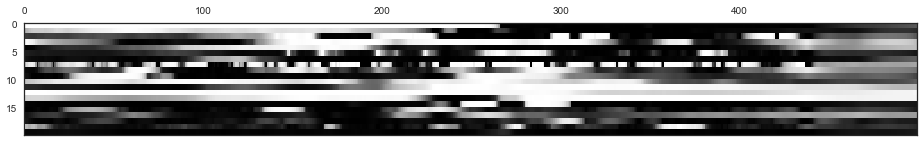

In [19]:
# plot a section in time; each row is a regressor; bottom rows are inferred categories
trng = slice(1500, 2000)
matshow(edf.iloc[trng, :-K].values.T, vmin=0, vmax=1);

# zoom in on inferred
matshow(edf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

## Overlap analysis:

Define the overlap as the maximum of the match or mismatch percentage. That is, if $x$ and $y$ are binary vectors, 
$$
\mathrm{overlap} = \max \{ \mathbb{E}[xy + (1-x)(1-y)], \mathbb{E}[(1-x)y + x(1-y)]\}
$$

In [20]:
match = (edf.T.dot(edf) + (1 - edf.T).dot(1 - edf)) / T
mismatch = (edf.T.dot(1 - edf) + (1 - edf.T).dot(edf)) / T
overlap = np.maximum(match, mismatch)

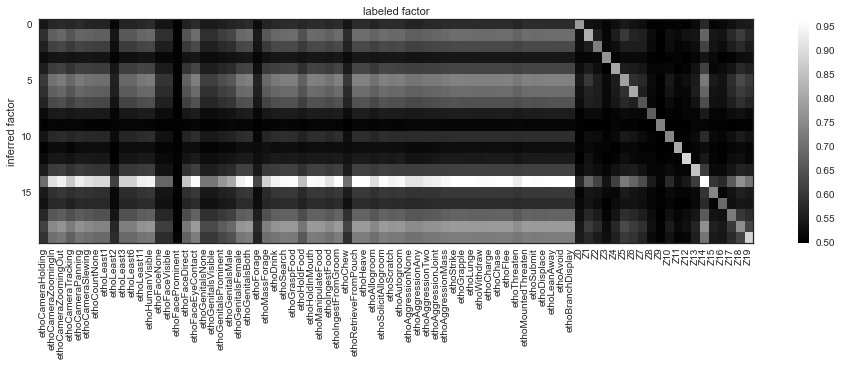

In [21]:
row_labels = edf.columns[:]
matshow(overlap.values[-K:,:]) #, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

In [22]:
overlap.iloc[-K:, :]

,ethoCameraHolding,ethoCameraZoomingIn,ethoCameraZoomingOut,ethoCameraTracking,ethoCameraPanning,ethoCameraSlewing,ethoCountNone,ethoLeast1,ethoLeast2,ethoLeast3,...,Z10,Z11,Z12,Z13,Z14,Z15,Z16,Z17,Z18,Z19
Z0,0.541641,0.569480,0.577495,0.572028,0.578651,0.568580,0.566503,0.566503,0.513733,0.567230,...,0.506860,0.507659,0.502014,0.518766,0.575877,0.509976,0.516774,0.528880,0.547018,0.550596
Z1,0.586157,0.672365,0.687393,0.655358,0.683649,0.680328,0.673255,0.673255,0.540804,0.659626,...,0.525785,0.516621,0.533096,0.536540,0.683886,0.541397,0.535818,0.574244,0.610368,0.574501
Z2,0.560224,0.619896,0.628478,0.607758,0.626753,0.618237,0.613692,0.613692,0.526460,0.609768,...,0.522155,0.508605,0.513806,0.526269,0.622960,0.535386,0.523318,0.550957,0.578827,0.550472
Z3,0.523149,0.537696,0.540639,0.534988,0.538293,0.540125,0.537238,0.537238,0.508909,0.530050,...,0.505676,0.507979,0.500221,0.512716,0.536956,0.517256,0.500727,0.508475,0.521977,0.527857
Z4,0.553387,0.609568,0.618865,0.597960,0.616536,0.612558,0.609405,0.609405,0.543243,0.613684,...,0.514918,0.500551,0.508996,0.533446,0.618505,0.514408,0.521847,0.536602,0.572908,0.559439
Z5,0.606614,0.706851,0.723197,0.689072,0.719710,0.706649,0.699950,0.699950,0.558567,0.689372,...,0.546917,0.515118,0.527473,0.547989,0.720966,0.548080,0.534468,0.585140,0.635788,0.606414
Z6,0.589070,0.672886,0.688067,0.655454,0.685887,0.676809,0.670652,0.670652,0.557826,0.666102,...,0.536419,0.515068,0.516273,0.554304,0.685843,0.536704,0.534162,0.573401,0.609183,0.590979
Z7,0.565269,0.632049,0.643098,0.620111,0.640628,0.632902,0.627637,0.627637,0.537997,0.623979,...,0.521633,0.507218,0.512582,0.533888,0.640574,0.532517,0.528876,0.555227,0.589001,0.567562
Z8,0.519972,0.545656,0.549435,0.542209,0.548243,0.546767,0.546469,0.546469,0.509368,0.544888,...,0.508640,0.504710,0.509405,0.510548,0.547985,0.511059,0.509442,0.522955,0.529340,0.519482
Z9,0.503960,0.511117,0.510029,0.509306,0.509594,0.505793,0.503928,0.503928,0.505841,0.510304,...,0.500551,0.501924,0.503080,0.509124,0.510005,0.505464,0.504517,0.500057,0.504507,0.506668


Try using the MPM (maximizer of posterior marginals) rather than the posterior:

In [23]:
# round to 0 or 1 elementwise
medf = np.around(edf)

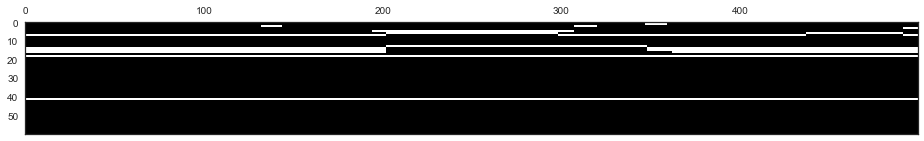

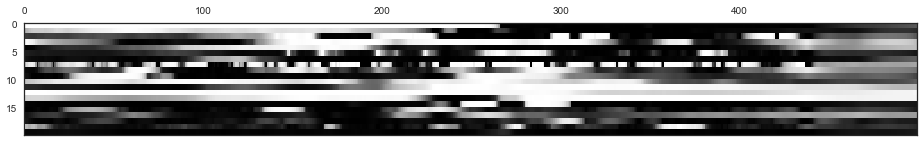

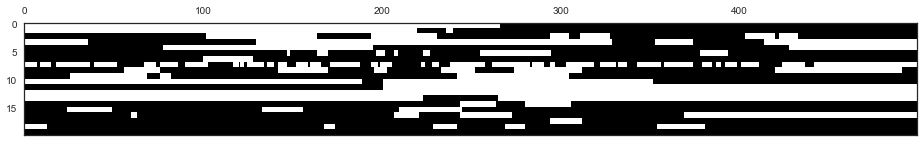

In [24]:
# plot a section in time; each row is a regressor; bottom rows are inferred categories
trng = slice(1500, 2000)
matshow(edf.iloc[trng, :-K].values.T, vmin=0, vmax=1);

# zoom in on inferred
matshow(edf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

# use MPM
matshow(medf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

In [25]:
mmatch = (medf.T.dot(medf) + (1 - medf.T).dot(1 - medf)) / T
mmismatch = (medf.T.dot(1 - medf) + (1 - medf.T).dot(medf)) / T
moverlap = np.maximum(mmatch, mmismatch)

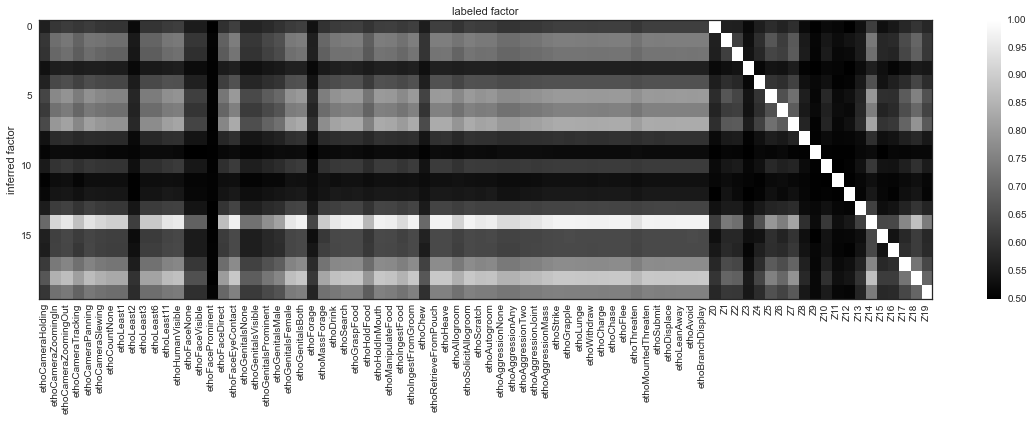

In [26]:
row_labels = medf.columns[:]
matshow(moverlap.values[-K:,:]) #, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');
plt.gcf().set_size_inches([20, 5])

In [27]:
moverlap.iloc[-K:, :]

,ethoCameraHolding,ethoCameraZoomingIn,ethoCameraZoomingOut,ethoCameraTracking,ethoCameraPanning,ethoCameraSlewing,ethoCountNone,ethoLeast1,ethoLeast2,ethoLeast3,...,Z10,Z11,Z12,Z13,Z14,Z15,Z16,Z17,Z18,Z19
Z0,0.560931,0.607047,0.618525,0.607636,0.620337,0.605939,0.602215,0.602215,0.521217,0.601835,...,0.520084,0.514111,0.500347,0.534361,0.621154,0.529650,0.548599,0.577278,0.603668,0.576578
Z1,0.606877,0.715863,0.734044,0.694121,0.729805,0.724649,0.716450,0.716450,0.551028,0.697121,...,0.546742,0.524379,0.537316,0.554648,0.739384,0.577118,0.583290,0.647014,0.699080,0.611182
Z2,0.599707,0.702010,0.717061,0.682043,0.714597,0.699259,0.692742,0.692742,0.546354,0.683100,...,0.553585,0.517193,0.520303,0.553368,0.718450,0.577321,0.573895,0.636972,0.687746,0.608799
Z3,0.533700,0.558834,0.563477,0.555253,0.559991,0.559712,0.555852,0.555852,0.517515,0.549011,...,0.514439,0.511517,0.500234,0.524557,0.561358,0.529994,0.510487,0.526178,0.551566,0.545566
Z4,0.568096,0.641572,0.652749,0.627859,0.650504,0.641412,0.637723,0.637723,0.556335,0.644654,...,0.533210,0.505483,0.508421,0.550647,0.658539,0.537002,0.562291,0.589495,0.636594,0.589704
Z5,0.635597,0.767234,0.788122,0.742383,0.784051,0.766376,0.757857,0.757857,0.574477,0.743405,...,0.582032,0.521241,0.532925,0.573501,0.795698,0.592870,0.590728,0.678149,0.752300,0.660454
Z6,0.613568,0.721466,0.741261,0.700332,0.738922,0.725336,0.717504,0.717504,0.568935,0.711213,...,0.566178,0.524941,0.518949,0.577069,0.746696,0.569315,0.583255,0.651766,0.703504,0.631540
Z7,0.645534,0.795031,0.818022,0.765159,0.813338,0.796295,0.785506,0.785506,0.581304,0.773683,...,0.571272,0.516926,0.532083,0.589672,0.824003,0.601156,0.613262,0.696641,0.787459,0.676505
Z8,0.536772,0.585002,0.591697,0.578417,0.589175,0.584441,0.583171,0.583171,0.518933,0.579857,...,0.522275,0.511659,0.512634,0.523420,0.593160,0.531213,0.537775,0.564456,0.581725,0.547881
Z9,0.510623,0.521807,0.522247,0.520195,0.521165,0.517882,0.515153,0.515153,0.510731,0.521553,...,0.504385,0.502949,0.503589,0.515763,0.523492,0.501256,0.514837,0.512742,0.516949,0.516715


In [28]:
moverlap.iloc[-K:, :-K].max()

ethoCameraHolding        0.706988
ethoCameraZoomingIn      0.918996
ethoCameraZoomingOut     0.952146
ethoCameraTracking       0.878231
ethoCameraPanning        0.945188
ethoCameraSlewing        0.920775
ethoCountNone            0.904840
ethoLeast1               0.904840
ethoLeast2               0.621808
ethoLeast3               0.892471
ethoLeast6               0.892471
ethoLeast11              0.947937
ethoHumanVisible         0.958016
ethoFaceNone             0.692046
ethoFaceVisible          0.692046
ethoFaceProminent        0.509065
ethoFaceDirect           0.871936
ethoFaceEyeContact       0.972574
ethoGenitalsNone         0.722603
ethoGenitalsVisible      0.722603
ethoGenitalsProminent    0.780904
ethoGenitalsMale         0.817634
ethoGenitalsFemale       0.951253
ethoGenitalsBoth         0.973272
ethoForage               0.634877
ethoMassForage           0.895237
ethoDrink                0.954425
ethoSearch               0.969472
ethoGraspFood            0.971093
ethoHoldFood  

### What is chance overlap?

How much overlap should we expect by chance, simply based on raw statistics? Let's generate some sequences from the fitted model and look at their overlap.

In [29]:
A = gpm.nodes['HMM'].nodes['A']
pi = gpm.nodes['HMM'].nodes['pi']
dnode = gpm.nodes['HMM'].nodes['d']

In [30]:
def get_duration(mu, lam, shape, rate):
    """
    Given tuple of normal-gamma parameters, draw a duration (max = D) from
    the appropriate lognormal distribution.
    """
    while True:
        d = lognormal_from_hypers(mu, lam, shape, rate, 1)
        if (d >= 1) and (d <= gpm.D):
            break
    
    return d

In [31]:
def make_chain(A, pi, mu, lam, shape, rate):
    """
    Generate a latent state sequence. A and pi are Markov parameters. Other
    arguments specify normal-gamma hyperparameters to a lognormal duration 
    distribution.
    """

    chain = np.empty((T,))

    # initialize
    t = 0
    while t < T:
        if t == 0:
            pp = pi[1]
        else:
            pp = A[1, chain[t - 1]]

        # pick a new state
        z = stats.bernoulli.rvs(pp, size=1)

        # pick a duration
        d = get_duration(mu[z], lam[z], shape[z], rate[z]).astype('int')
        d = np.min([d, gpm.T - d])

        # fill in the next d steps of the chain
        chain[t:(t+d)] = z
        t += d
            
    return chain

In [32]:
def generate_fake_chains(nfake):
    fakechains = np.empty((T, K * nfake))

    for kk in xrange(K):

        # draw nfake transition matrices from posterior
        fakeA = np.empty(A.post.shape[:2] + (nfake,))
        for idx in xrange(fakeA.shape[1]):
            fakeA[:, idx, :] = stats.dirichlet.rvs(A.post[:, idx, kk], size=nfake).T

        # same for pi
        fakepi = np.empty(pi.post.shape[:1] + (nfake,))
        fakepi = stats.dirichlet.rvs(pi.post[..., kk], size=nfake).T

        # get poster parameters for duration distribution
        mu = dnode.parent.post_mean[:, kk]
        lam = dnode.parent.post_scaling[:, kk]
        alpha = dnode.parent.post_shape[:, kk]
        beta = dnode.parent.post_rate[:, kk]

        for idx in xrange(nfake):
            fakechains[:, kk * nfake + idx] = make_chain(fakeA[..., idx], fakepi[..., idx], mu, lam, alpha, beta)

    return fakechains

In [33]:
%%time
nfake = 100  # number of fake sequences for each chain
fchains = generate_fake_chains(nfake)

CPU times: user 1h 49min 5s, sys: 10.5 s, total: 1h 49min 16s
Wall time: 1h 49min 22s


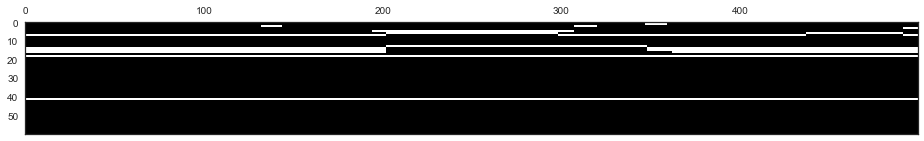

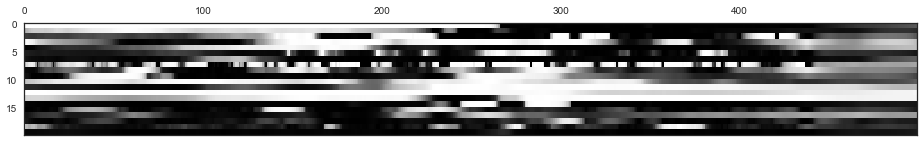

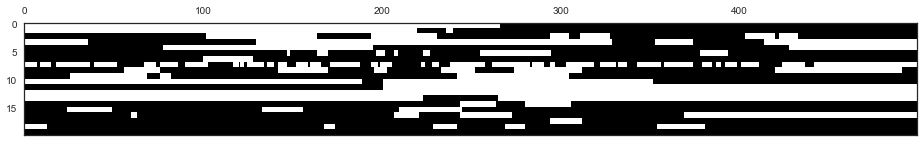

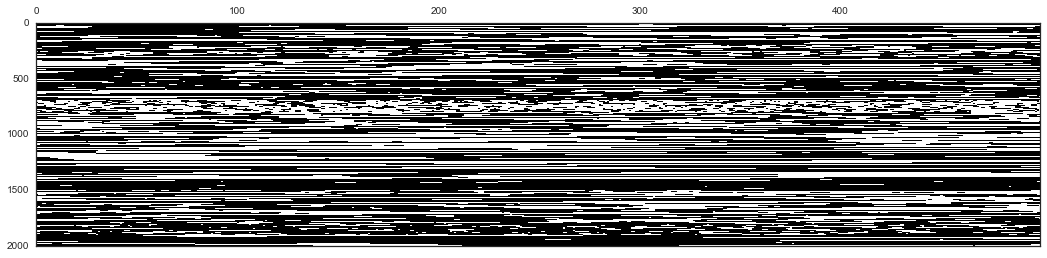

In [34]:
trng = slice(1500, 2000)
matshow(edf.iloc[trng, :-K].values.T, vmin=0, vmax=1);

# zoom in on inferred
matshow(edf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

# use MPM
matshow(medf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

# use fake chains
matshow(fchains[trng].T, vmin=0, vmax=1);
plt.gcf().set_size_inches([18, 4])

Calculate overlap with actual ethogram:

In [35]:
fmatch = (edf.T.dot(fchains) + (1 - edf.T).dot(1 - fchains)) / T
fmismatch = (edf.T.dot(1 - fchains) + (1 - edf.T).dot(fchains)) / T
foverlap = np.maximum(fmatch, fmismatch)

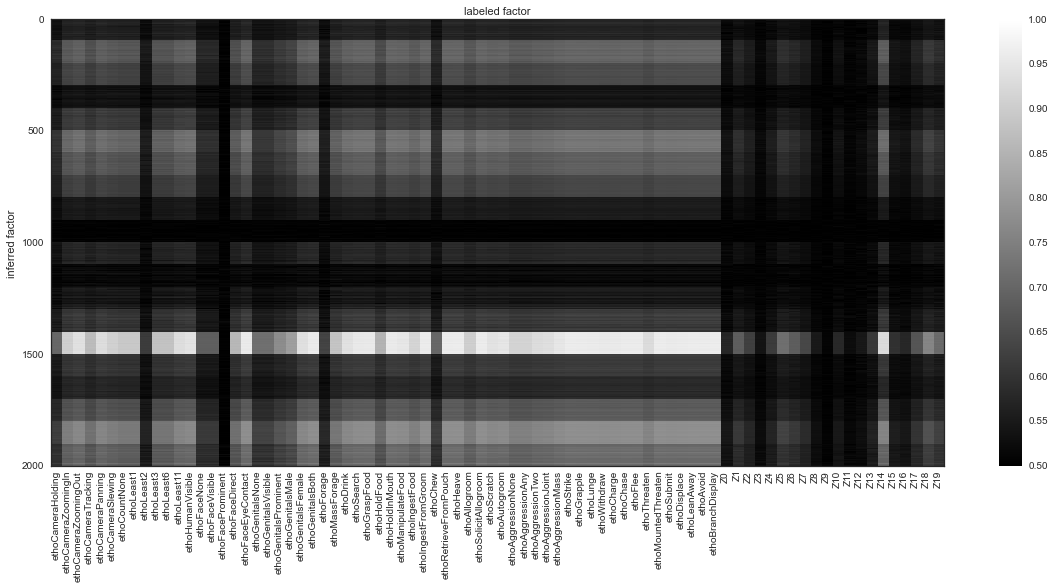

In [36]:
row_labels = edf.columns[:]
matshow(foverlap.values.T, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5);
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

plt.gcf().set_size_inches([20, 8])

In [37]:
foverlap.max(axis=1)

ethoCameraHolding       0.705216
ethoCameraZoomingIn     0.910536
ethoCameraZoomingOut    0.942375
ethoCameraTracking      0.870483
ethoCameraPanning       0.936703
ethoCameraSlewing       0.912401
ethoCountNone           0.897738
ethoLeast1              0.897738
ethoLeast2              0.620351
ethoLeast3              0.885977
ethoLeast6              0.885977
ethoLeast11             0.937850
ethoHumanVisible        0.946916
ethoFaceNone            0.690979
ethoFaceVisible         0.690979
...
Z5     0.720974
Z6     0.685376
Z7     0.640499
Z8     0.550965
Z9     0.514396
Z10    0.581520
Z11    0.528691
Z12    0.549841
Z13    0.614414
Z14    0.931219
Z15    0.599111
Z16    0.578722
Z17    0.670457
Z18    0.763842
Z19    0.713221
Length: 80, dtype: float64

In [38]:
foverlap.mean(axis=1)

ethoCameraHolding       0.561974
ethoCameraZoomingIn     0.624513
ethoCameraZoomingOut    0.634350
ethoCameraTracking      0.612546
ethoCameraPanning       0.632224
ethoCameraSlewing       0.625022
ethoCountNone           0.620351
ethoLeast1              0.620351
ethoLeast2              0.535994
ethoLeast3              0.616553
ethoLeast6              0.616553
ethoLeast11             0.632590
ethoHumanVisible        0.635785
ethoFaceNone            0.557292
ethoFaceVisible         0.557292
...
Z5     0.566421
Z6     0.556273
Z7     0.542741
Z8     0.515138
Z9     0.504043
Z10    0.524316
Z11    0.508331
Z12    0.514766
Z13    0.533993
Z14    0.630892
Z15    0.529772
Z16    0.523588
Z17    0.551211
Z18    0.580034
Z19    0.564342
Length: 80, dtype: float64

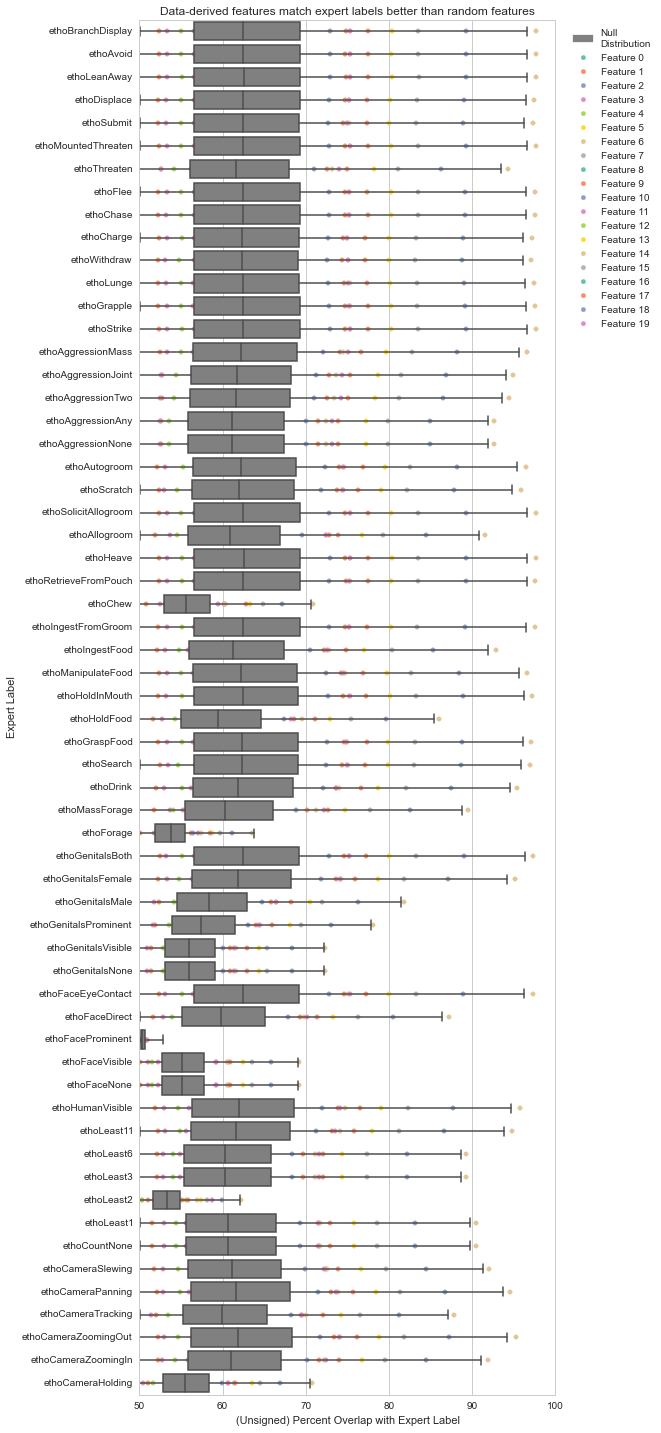

In [43]:
fov = foverlap.T.iloc[:, :-K] * 100
mov = moverlap.iloc[-K:, :-K] * 100
with sns.axes_style('whitegrid'):
    # plot data from the null distribution
    sns.boxplot(fov, vert=False, whis=1000, color='gray', label='Null\nDistribution')
    
    colors = sns.color_palette(name='Set2', n_colors=K)
    # plot data from fitted categories
    for idx in range(mov.shape[0]):
        dat = mov.iloc[idx].values
        label = 'Feature {}'.format(idx)
        plt.scatter(dat, np.arange(dat.size) + 1, color=colors[idx], label=label)
        
    plt.xlim(50, 100)
    plt.title('Data-derived features match expert labels better than random features')
    plt.xlabel('(Unsigned) Percent Overlap with Expert Label')
    plt.ylabel('Expert Label')
    plt.gcf().set_size_inches([8, 20])
    plt.legend(bbox_to_anchor=(1.25, 1.0))
    plt.gcf().tight_layout()
    plt.savefig("output/figs/overlap.svg")